In [1]:
exec(open("init_notebook.py", "r").read())
%load_ext autoreload
%autoreload 2

current working dirC:\AV\Carla\CARLA_0.9.13\WindowsNoEditor\PythonAPI\experiments


In [2]:
from shapely.geometry import Polygon, Point, LineString
from shapely.affinity import rotate
import matplotlib.pyplot as plt
import math
import random
import seaborn as sb
# from agents.pedestrians.destination import CrosswalkGeometry

In [44]:

class CrosswalkGeometry:
    '''
    Geometric information of CrosswalkModel, including source, idealDestination, areaPolygon, and goalLine.

    CONSTANTS:
        MAX_ABSOLUTE_DEGREE: float
        MAX_RELATIVE_DEGREE: float
        INTER_POINTS_NUM: int
        INTER_POINTS_DISTANCE_MOD: float
    '''
    MAX_ABSOLUTE_DEGREE = math.radians(60)
    MAX_RELATIVE_DEGREE = math.radians(45)
    INTER_POINTS_NUM = 3
    INTER_POINTS_DISTANCE_MOD = 1.5

    def __init__(self, source: Point, idealDestination: Point=None, areaPolygon: Polygon=None, goalLine: LineString=None):
        self.source = source
        self.idealDestination = idealDestination
        self.areaPolygon = areaPolygon
        self.goalLine = goalLine
        self.intermediatePoints = []
        self.finalDestination = None
        self.nextIntermediatePointIdx = None
        if self.areaPolygon == None:
            self.createPolygonIfNone()
        self.generateIntermediatePoints()
    
    def createPolygonIfNone(self):
        # TODO: we make a generic one which may be based on real world dataset. Also create a goal line
        if self.goalLine == None:
            self.createGoalLine(4)
       
        self.areaPolygon = self.genPolyArea(self.source, self.idealDestination, self.goalLine)


    def genPolyArea(self, start: Point, end: Point, goalLine: LineString):
        '''
        Generate a generic areaPolygon given a start point, end point and a goalLine.
        
        Args:
            start (shapely.geometry.Point): the point where the pedestrian enters the crosswalk.
            end (shapely.geometry.Point): the ideal point where the pedestrian exits the crosswalk.
            goalLine (shapely.geometry.LineString): the sidewalk which contains the end point.

        Returns:
            areaPolygon (shapely.geometry.Polygon): the generated polygon that forms the area of an abstract crosswalk space.
        '''
        # Extract goalLine information
        goalLine_x1, goalLine_y1 = goalLine.coords[0][0], goalLine.coords[0][1] 
        goalLine_x2, goalLine_y2 = goalLine.coords[1][0], goalLine.coords[1][1]
        # Generate base as perpendicular to the vertical line
        
        if end is None:
            end = self.closestEnd(start, goalLine)
            
        verticalLine = LineString([start, end])
        baseRight = rotate(verticalLine, -90, origin=start)
        baseLeft = rotate(verticalLine, 90, origin=start)
        # Bottom left point
        botLeft = baseLeft.interpolate(0.5, normalized=False)
        botLeft_x = botLeft.coords[0][0]
        botLeft_y = botLeft.coords[0][1]
        # Bottom right point
        botRight = baseRight.interpolate(0.5, normalized=False)
        botRight_x = botRight.coords[0][0]
        botRight_y = botRight.coords[0][1]
        # Top left point
        topLeft_x = goalLine_x1
        topLeft_y = goalLine_y1
        topLeft = Point((topLeft_x, topLeft_y))
        # Top right point
        topRight_x = goalLine_x2
        topRight_y = goalLine_y2
        topRight = Point((topRight_x, topRight_y))
        # Mid left point
        midLeft_x = min(botLeft_x, topLeft_x) + (max(botLeft_x, topLeft_x) - min(botLeft_x, topLeft_x))/1.5
        midLeft_y = (topLeft_y - botLeft_y)/2
        midLeft = Point((midLeft_x, midLeft_y))
        # Mid right point
        midRight_x = min(botRight_x, topRight_x) + (max(botRight_x, topRight_x) - min(botRight_x, topRight_x))/3
        midRight_y = (topRight_y - botRight_y) / 2
        midRight = Point((midRight_x, midRight_y))

        # Build areaPolygon
        areaPolygon = Polygon([botLeft, midLeft, topLeft, topRight, midRight, botRight])
        return areaPolygon


    def generateIntermediatePoints(self, maxAbsDegree=MAX_ABSOLUTE_DEGREE, maxDeltaDegree=MAX_RELATIVE_DEGREE, nInterPoints=INTER_POINTS_NUM, maxInterPointsDistance=INTER_POINTS_DISTANCE_MOD):
        '''
        Generate intermediate points inside the crosswalk area to form pedestrian crossing trajectories. 

        Args:
            maxAbsDegree (float): the maximum degree between the new line and the vertical line that shares the same start point
            maxDeltaDegree (float): the maximum degree between the new line and the extended previous line. The end point of the previous line is the start point of the new line
            nInterPoints (int): the number of intermediates points to be generated
            maxInterPointsDistance (float): the scalar modifier for the max distance between any two intermediate points

        Returns:
            None
        '''
        start = self.source
        if self.idealDestination is None:
            # Find vertical line
            D_final = self.closestEnd(start, self.goalLine)
        else:
            D_final = self.idealDestination
        crosswalk = self.areaPolygon
        waypoints = [start]
        
        for i in range(nInterPoints):
            W_pre1 = waypoints[-1]
            W_pre2 = waypoints[-2] if len(waypoints) > 1 else None
            
            pointsOL = self.pointsOnLine(W_pre1, D_final, nInterPoints)
            A = pointsOL[1]
            B = pointsOL[2]
            
            # print("W_pre1", W_pre1, "A", A, "B", B)
            done = False
            
            while not done:
                chance = random.choice([0, 1])
                C = self.pointBetween(A, B, d=random.uniform(0, 1)) # modify d if needed
                if chance == 0:
                    C = self.pointRotate(C, A, degree=90)
                    
                else:
                    C = self.pointRotate(C, A, degree=-90)
                    
                # Check constraints
                if crosswalk.contains(C):
                    # print(f"C, {C} inside the area")
                    lineAB = LineString([A, B])
                    line_W_pre1_C = LineString([W_pre1, C])
                    line_W_pre1_W_pre2 = None
                    if i > 0:
                        line_W_pre1_W_pre2 = LineString([W_pre2, W_pre1])
                    if line_W_pre1_C.length <= lineAB.length*maxInterPointsDistance:
                        # print(f"line_W_pre1_C.length, {line_W_pre1_C.length} is good")
                        if line_W_pre1_W_pre2 == None:
                            done = True
                        else:
                            # if the ideal destination is None, we are free to explore
                            
                            if self.idealDestination is None:
                                # Find vertical line
                                D_final = self.closestEnd(W_pre1, self.goalLine)
                                # print(f"ideal destination is None, D_final is {D_final}")
                            else:
                                D_final = self.idealDestination
                                
                            destinationLine = LineString([W_pre1, D_final])
                            
                            
                            # Calculate the angle between the new line and the vertical line
                            a_theta = self.degreeFromX(destinationLine) - self.degreeFromX(line_W_pre1_C)
                            # Calculate the angle between the new line and the extended previous line
                            d_theta = self.degreeFromX(line_W_pre1_W_pre2) - self.degreeFromX(line_W_pre1_C)
                        

                            if maxAbsDegree*(-1) <= a_theta <= maxAbsDegree and maxDeltaDegree*(-1) <= d_theta <= maxDeltaDegree:
                                done = True
                            # else:
                            #     print("a_theta", math.degrees(a_theta), "b_theta", math.degrees(d_theta))
                            #     waypoints.append(C)
                            #     print("returning to debug")
                            #     return waypoints
                    # else:
                    #     print(f"line_W_pre1_C.length, {line_W_pre1_C.length} is bad")
                    #     waypoints.append(C)
                    #     print("returning to debug")
                    #     return waypoints
                        
            
            # print(f"iteration-{i}, C, {C} satisfies the constraints")
            
            waypoints.append(C)
#             new_start = C
#             extend_end = new_line.interpolate(10, normalized=True)
#             new_end = self.closestEnd(extend_end, self.goalLine)
            
#             pointsOL = self.pointsOnLine(new_start, new_end, nInterPoints-(i+1))

        # final rotate to find end point is different
    
        if self.idealDestination is not None:
            # Find vertical line
            waypoints.append(self.idealDestination)
        else:
        
            D_final = self.closestEnd(W_pre1, self.goalLine)

            # Final destination point works in the reversed direction. We get the D_final and ...

            final_start = D_final
            final_end = waypoints[-1]
            done = False
            while not done:
                C = self.pointBetween(final_start, final_end, d=random.uniform(0, 1))
                chance = random.random()
                if chance > 0.5:
                    C = self.pointRotate(C, final_start, degree=90)
                else:
                    C = self.pointRotate(C, final_start, degree=-90)

                segment = LineString([final_start, final_end])
                line_W_pre1_C = LineString([waypoints[-1], C])
                line_W_pre1_W_pre2 = LineString([waypoints[-2], waypoints[-1]])
                if line_W_pre1_C.length <= segment.length*maxInterPointsDistance:
                    # Find vertical line
                    vert_start = waypoints[-1]
                    vert_end = self.closestEnd(vert_start, self.goalLine)
                    destinationLine = LineString([vert_start, vert_end])
                    # Calculate the angle between the new line and the vertical line
                    a_theta = self.degreeFromX(destinationLine) - self.degreeFromX(line_W_pre1_C)
                    # Calculate the angle between the new line and the extended previous line
                    d_theta = self.degreeFromX(line_W_pre1_W_pre2) - self.degreeFromX(line_W_pre1_C)

                    if abs(a_theta) <= maxAbsDegree and abs(d_theta) <= maxDeltaDegree:
                        done = True

            if self.goalLine.contains(C) == False:
                C = self.closestEnd(C, self.goalLine)
            waypoints.append(C)
            
        # 1. set intermediatePoints[] to the generated waypoints[]
        self.intermediatePoints = waypoints[1:]

        # 2. set nextIntermediatePointIdx to index 0
        self.nextIntermediatePointIdx = 0

        # 3. set self.finalDestination to the last item in waypoints[]
        self.finalDestination = waypoints[-1]

        return self.intermediatePoints




    # region 
    def degreeFromX(self, line: LineString): # TODO move to lib/Geometry
        """
        Find the angle in radian between a given line and the x-axis.
        
        Args:
            line (shapely.LineString): a line

        Returns:
            theta (float): angle in radians
        """
        # Extract points from line1 and line2
        x = line.coords[1][0] - line.coords[0][0]
        y = line.coords[1][1] - line.coords[0][1]

        # Find theta using formula
        theta = math.atan2(y, x)

        return theta

    def closestEnd(self, point: Point, goalLine: LineString):
        """
        Given a point A and a line Y, find the point B on Y such that the line AB is the shortest.

        Args:
            point (shapely.geometry.Point): point A
            goalLine (shapely.geometry.LineString): line Y

        Returns:
            end (shapely.geometry.Point): point B
        """
        d = goalLine.project(point)
        end = goalLine.interpolate(d)
        return end

    def pointBetween(self, start: Point, end: Point, d: float):
        """
        Given point A and point B, find a point C in between AB that is d distance away from A.
        
        Args:
            start (shapely.geometry.Point): point A
            end (shapely.geometry.Point): point B
            d (float): a scalar multiplier to the normalized distance between point A and point B

        Returns:
            point (shapely.geometry.Point): point C
        """
        line = LineString([start, end])
        point = line.interpolate(d, normalized=True)
        return point

    def pointRotate(self, point: Point, origin: Point, degree=90):
        """
        Given a point A and an origin O, rotate A +-90 degrees around O to get point B.

        Args:
            point (shapely.geometry.Point): point A
            origin (shapely.geometry.Point): point O
            degree (int, optional): degree of rotation. Defaults to 90

        Returns:
            rotated_point (shapely.geometry.Point): point B
        """
        rotated_point = rotate(point, degree, origin=origin)
        return rotated_point

    def pointsOnLine(self, start: Point, end: Point, n: int, excludeEnds=False):
        """
        Given a start point A and an end point B, generate n number of evenly spaced points between the line AB.

        Args:
            start (shapely.geometry.Point): point A
            end (shapely.geometry.Point): point B
            n (int): number of points between the line AB

        Returns:
            pointsOL[(shapely.geometry.Point)]: the array of generated points between AB
        """
        pointsOL = [start]
        line = LineString([start, end])
        gap = 1 / (n + 1)
        d = gap
        for i in range(n):
            point = line.interpolate(d, normalized=True)
            d = d + gap
            pointsOL.append(point)
        pointsOL.append(end)
        
        # print("pointsOL", pointsOL)
        
        if excludeEnds:
            # print("pointsOL", pointsOL)
            # for p in pointsOL:
            #     print(p)
            return pointsOL[1:len(pointsOL)-1]
        return pointsOL
    # endregion

In [45]:
# Case 2: changing ideal destination point
# Plot polygons and points
goalLine = LineString([(0, 12), (12, 12)])
start = Point(6, 0)
endPoints = [Point(0, 12), Point(3, 12), Point(6, 12), Point(9, 12), Point(12, 12)]
end = Point(6, 12)
p = None
nIntermediate = 3

In [46]:
crosswalkGeometry = CrosswalkGeometry(
            source=start,
            idealDestination=end,
            areaPolygon=p,
            goalLine=goalLine
        )

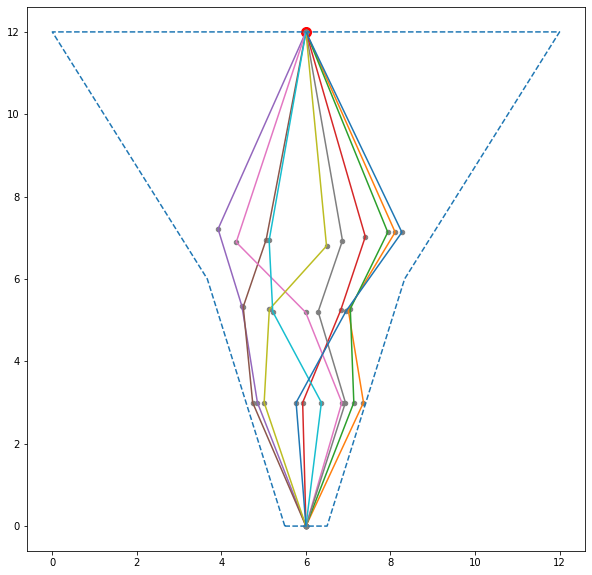

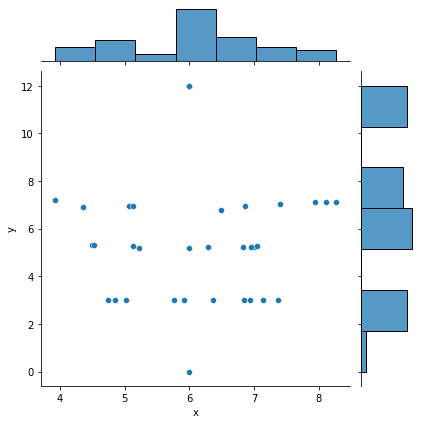

In [49]:
data = {'x': [], 'y': []}

p = crosswalkGeometry.areaPolygon
x,y = p.exterior.xy

plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x,y, '--')
plt.scatter(end.x, end.y, s=100, color='red')

maxAbsDegree = math.radians(60)
maxDeltaDegree = math.radians(45)

for i in range(10):
    line_x = []
    line_y = []
    waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5)
    
    waypoints.insert(0, start)
    

    for j in range(len(waypoints)):
        line_x.append(waypoints[j].x)
        line_y.append(waypoints[j].y)

        if waypoints[j].y != start.y:
            data['x'].append(waypoints[j].x)
            data['y'].append(waypoints[j].y)

        plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='grey')
        

    plt.plot(line_x, line_y)

# plt.savefig("figures/control.png")
# Visualizing data
data['x'].append(start.x)
data['y'].append(start.y)
fig = sb.jointplot(data=data, x='x', y='y')
# fig.savefig("figures/control_dist.png")